In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird

Some aesthetic definitions for the plots

In [2]:
font = {'size': 16, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

## Linear power spectrum

Instantiate a Class object, set parameters and compute

In [161]:
zpk = 0.6

M = Class()


cosmo = {'ln10^{10}A_s': 3.044,
       'n_s': 0.9649,
       'h': 0.6736,
       'omega_b': 0.02237,
       'omega_cdm': 0.120,
      }

M.set(cosmo)

M.set({'output': 'mPk',
       'P_k_max_1/Mpc': 1.0,
       'z_max_pk': zpk})

M.compute()

Get the linear power spectrum at redshift zpk, and plot it

In [4]:
# k in h/Mpc
kk = np.logspace(-5, 0, 200)

# P(k) in (Mpc/h)**3
Pk = [M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]

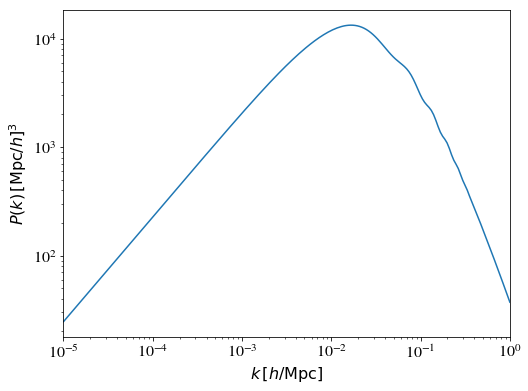

In [5]:
plt.figure()

plt.plot(kk, Pk, 'C0-')

plt.xscale('log')
plt.yscale('log')

plt.xlim(kk[0], kk[-1])

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

## Loading PyBird

Define a vector with the bias parameters bs = [b1, b2, b3, b4, cct, cr1, cr2]

In [6]:
bs = [2., 0.8, 0.2, 0.8, 0.2, -4., 0]
bdict = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }
bdicth = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5] }

Define an object of the class Common, with settings for the pybird objects. 

In particular, choose the kmax (in h/Mpc) up to which to compute the nonlinear power spectrum and the number of multipoles Nl (2 or 3) to evaluate.

In [7]:
kmax = 0.3
common = pybird.Common(Nl=2, kmax=kmax, optiresum=True)

Instantiate the class that calculates the nonlinear power spectrum.
It will load precomputed FFTLog matrices if they are in the folder, otherwise it will compute new ones.

In [8]:
from time import time

In [9]:
from importlib import reload
reload(pybird)

time1 = time()
nonlinear = pybird.NonLinear(load=True, save=True, co=common)
print(time() - time1)

0.2495250701904297


Instantiate the class that calculates the resummed power spectrum

In [10]:
resum = pybird.Resum(co=common)

Finally, instantiate the class that applies the Alcock-Paczynski (AP) effect, the window function, the fiber collisions, and interpolate on the data kbins

In [11]:
kdata = np.linspace(0.005, 0.25, 50)
Om_AP = 0.31
z_AP = zpk

In [12]:
projection = pybird.Projection(kdata, Om_AP, z_AP, co=common)

## Nonlinear power spectrum

Now instantiate the main class

In [13]:
DA = M.angular_distance(zpk) * M.Hubble(0.)
H = M.Hubble(zpk) / M.Hubble(0.)
f = M.scale_independent_growth_factor_f(zpk)

cosmobird = { "k11": kk, "P11": Pk, "f": f, "DA": DA, "H": H }

bird = pybird.Bird(cosmobird, with_bias=True, co=common)

Call the routine to get the power spectrum (and correlation function), and compute it in the bird object. The correlation function is useful for the IR-resummation.

In [14]:
time1 = time()
nonlinear.PsCf(bird)
bird.setPsCf(bdict)
print(time()-time1)

noresumPs = np.copy(bird.fullPs)

0.2922680377960205


Compute the resummed power spectrum

In [15]:
time1 = time()
resum.Ps(bird)
print(time() - time1)

resumPs = np.copy(bird.fullPs)

0.2948188781738281


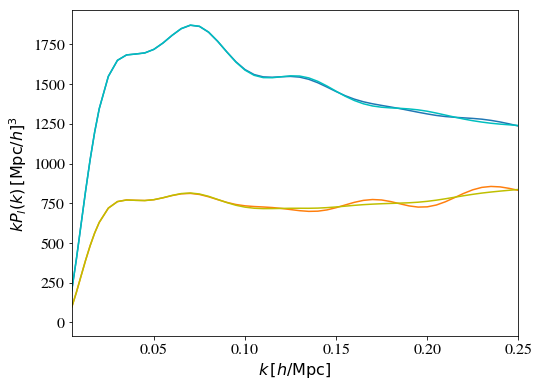

In [16]:
plt.figure()

plt.plot(common.k, common.k * noresumPs[0], 'C0-', label = 'mono noresum')
plt.plot(common.k, common.k * noresumPs[1], 'C1-', label = 'quad noresum')

plt.plot(common.k, common.k * resumPs[0], 'c-', label = 'mono resum')
plt.plot(common.k, common.k * resumPs[1], 'y-', label = 'quad resum')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

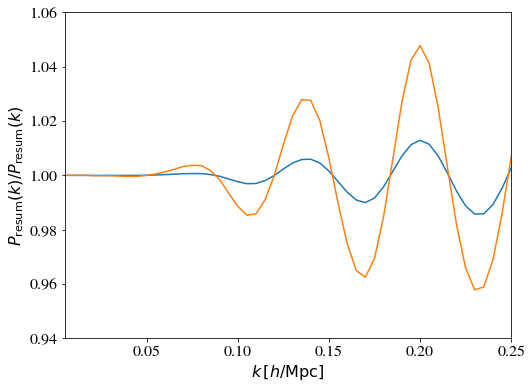

In [17]:
plt.figure()

plt.plot(common.k, resumPs[0]/noresumPs[0], 'C0-', label = 'mono')
plt.plot(common.k, resumPs[1]/noresumPs[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.ylim(0.94, 1.06)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm resum}(k)/P_{\rm resum}(k)$')

plt.show()

### New interface

In [18]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'xdata': common.k,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.31,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bdicth
})

newpk = correlator.get()


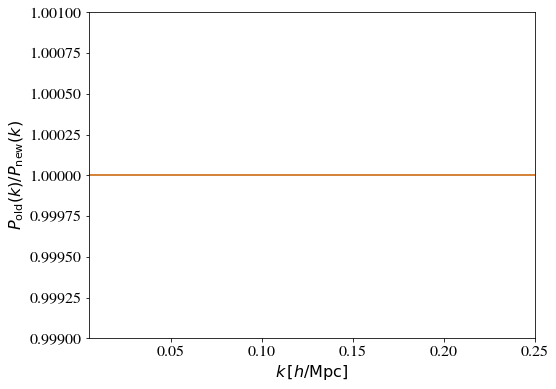

In [19]:
plt.figure()

plt.plot(common.k, resumPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(common.k, resumPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

In [20]:
#correlator.info()

## Nonlinear power spectrum II: unspecified EFT parameters

The power spectrum can also be computed without specifying the EFT parameters. This is interesting for subsampling them or to marginalize over the ones that appear only linearly in the power spectrum.

In [21]:
time1 = time()
raven = pybird.Bird(cosmobird, with_bias=False, co=common)
nonlinear.PsCf(raven)
raven.setPsCfl()
resum.Ps(raven)
print(time() - time1)

2.0083682537078857


The terms are given as follow:

In [22]:
b1, b2, b3, b4, b5, b6, b7 = bs
f = raven.f
b11 = np.array([ b1**2, 2.*b1*f, f**2 ])
bct = np.array([ 2.*b1*b5, 2.*b1*b6, 2.*b1*b7, 2.*f*b5, 2.*f*b6, 2.*f*b7 ])
bloop = np.array([ 1., b1, b2, b3, b4, b1*b1, b1*b2, b1*b3, b1*b4, b2*b2, b2*b4, b4*b4 ])
lin = np.einsum('b,lbx->lx', b11, raven.P11l)
loop = np.einsum('b,lbx->lx', bloop, raven.Ploopl) 
counterterm = np.einsum('b,lbx->lx', bct, raven.Pctl)
ravenPs = lin + loop + counterterm

The above is equivalent to the building function:

In [23]:
raven.setreducePslb(bdict)

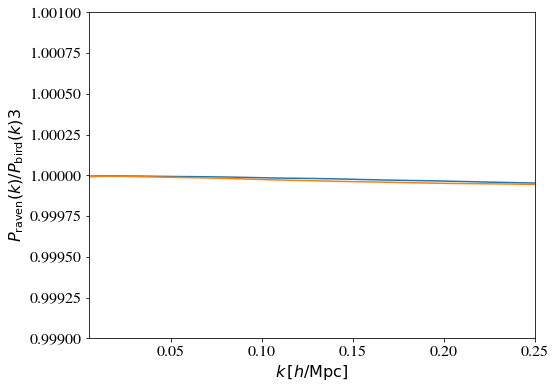

In [24]:
plt.figure()

plt.plot(common.k, raven.fullPs[0]/bird.fullPs[0], 'C0', label = 'mono')
plt.plot(common.k, raven.fullPs[1]/bird.fullPs[1], 'C1', label = 'quad')

plt.xlim(0.005, 0.25)
plt.ylim(1-.001, 1+.001)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$ P_{\rm raven}(k) / P_{\rm bird}(k)3$')

plt.show()

Here are plotted various contributions to the power spectrum:

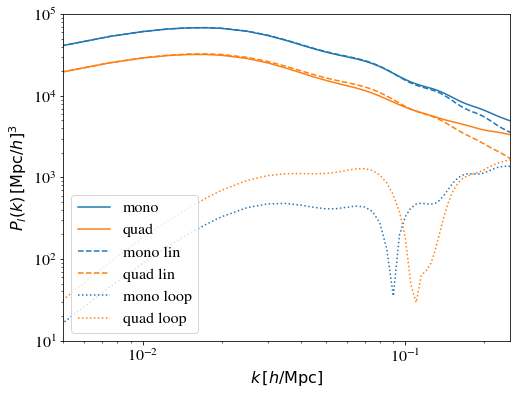

In [25]:
plt.figure()

plt.loglog(common.k, ravenPs[0], 'C0', label = 'mono')
plt.loglog(common.k, ravenPs[1], 'C1', label = 'quad')

plt.loglog(common.k, lin[0], 'C0--', label = 'mono lin')
plt.loglog(common.k, lin[1], 'C1--', label = 'quad lin')

plt.loglog(common.k, np.abs(loop[0]+counterterm[0]), 'C0:', label = 'mono loop')
plt.loglog(common.k, np.abs(loop[1]+counterterm[1]), 'C1:', label = 'quad loop')

plt.xlim(0.005, 0.25)
plt.ylim(10, 1e5)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.legend(loc='lower left')

plt.show()

### New interface

In [26]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'xdata': common.k,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.31,
    'with_bias': False
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
})

newpk = correlator.get(bdicth)

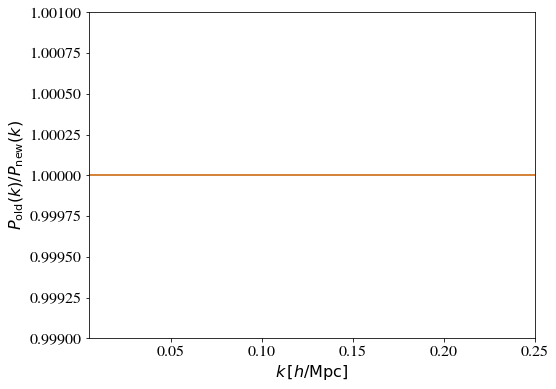

In [27]:
plt.figure()

plt.plot(common.k, raven.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(common.k, raven.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## Projection on the sky I

Finally, set the AP effect and interpolate on the k-array of the data

In [28]:
projection.AP(bird)
projection.xdata(bird)

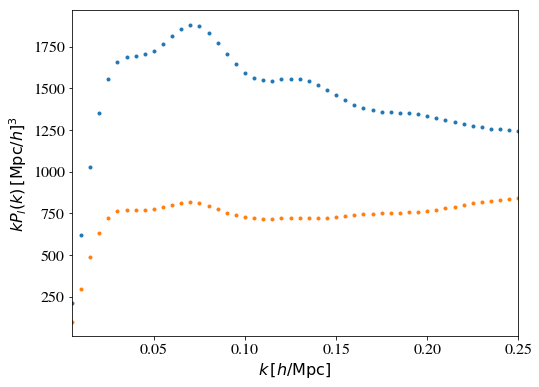

In [29]:
plt.figure()

plt.plot(kdata, kdata * bird.fullPs[0], 'C0.', label = 'mono')
plt.plot(kdata, kdata * bird.fullPs[1], 'C1.', label = 'quad')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

### New interface

In [30]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.31,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bdicth,
    'DA': DA,
    'H': H
})

newpk = correlator.get()

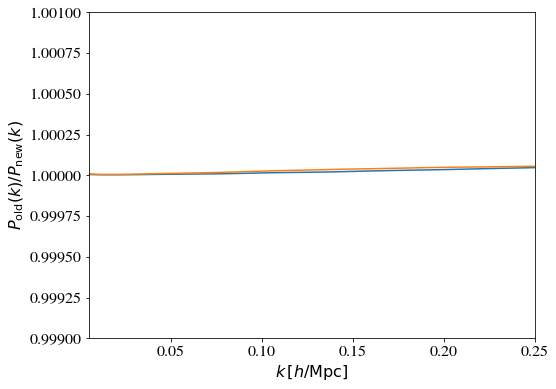

In [31]:
plt.figure()

plt.plot(kdata, bird.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, bird.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

Let us apply the window function now as convolution in Fourier space. First we redefine the projection class to include the mask. It will load precomputed Fourier convolution mask if it is in the folder, otherwise it will compute a new one from a provided mask in configuration space.

In [32]:
projection = pybird.Projection(kdata, Om_AP, z_AP, co=common,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='../montepython_tree/data/pybird/Window',
    window_configspace_file='../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat')

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl2_kmax0.30.npy


Here is a masked bird

In [33]:
plover = pybird.Bird(cosmobird, with_bias=True, co=common)
nonlinear.PsCf(plover)
plover.setPsCf(bdict)
resum.Ps(plover)
projection.AP(plover)
projection.Window(plover)
projection.xdata(plover)

(0.005, 0.25)

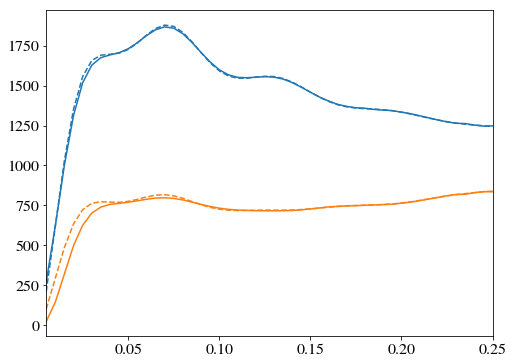

In [34]:
plt.plot(kdata, kdata*plover.fullPs[0], 'C0-')
plt.plot(kdata, kdata*plover.fullPs[1], 'C1-')
plt.plot(kdata, kdata*bird.fullPs[0], 'C0--')
plt.plot(kdata, kdata*bird.fullPs[1], 'C1--')
plt.xlim(0.005, 0.25)

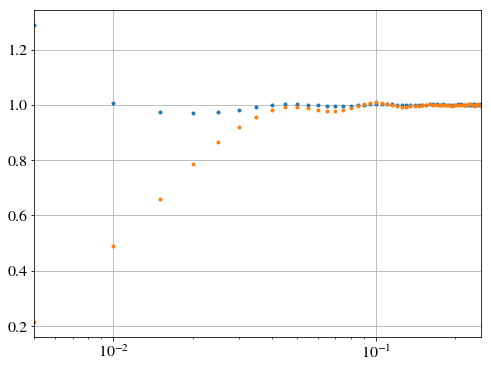

In [35]:
plt.plot(kdata, plover.fullPs[0]/bird.fullPs[0], 'C0.')
plt.plot(kdata, plover.fullPs[1]/bird.fullPs[1], 'C1.')
plt.grid()
plt.xlim(0.005, 0.25)
plt.xscale('log')

### New interface

In [36]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
    'with_window': True,
    'windowPk': '../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057',
    'windowCf': '../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat'
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bdicth,
    'DA': DA,
    'H': H
})

newpk = correlator.get()

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl2_kmax0.30.npy


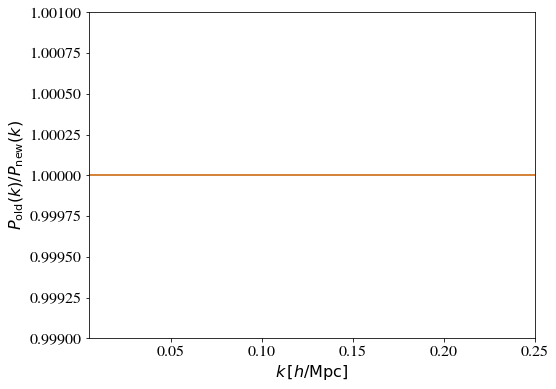

In [37]:
plt.figure()

plt.plot(kdata, plover.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, plover.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## Hexadecapole

PyBird can compute the hexadecapole. First we redefine the PyBird classes to include the hexadecapole. In particular, we set Nl=3 in the Common() class.

In [38]:
commonhex = pybird.Common(Nl=3, kmax=kmax, optiresum=True)
nonlinear = pybird.NonLinear(load=True, save=True, co=commonhex)
resum = pybird.Resum(co=commonhex)
projection = pybird.Projection(kdata, Om_AP, z_AP, co=commonhex,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='../montepython_tree/data/pybird/Window',
    window_configspace_file='../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat')

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


Here is the bird up to the hexadecapole

In [39]:
birdhex = pybird.Bird(cosmobird, with_bias=True, co=commonhex)
nonlinear.PsCf(birdhex)
birdhex.setPsCf(bdict)
resum.Ps(birdhex)
projection.AP(birdhex)
projection.Window(birdhex)
projection.xdata(birdhex)

(0.005, 0.25)

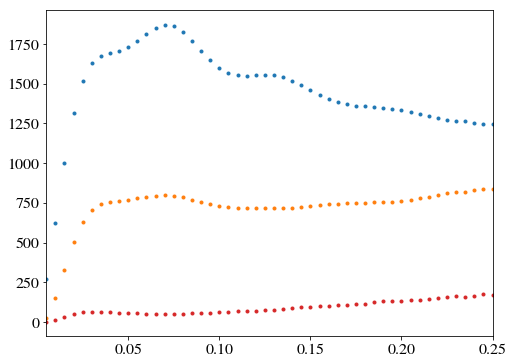

In [40]:
plt.plot(kdata, kdata*birdhex.fullPs[0], 'C0.')
plt.plot(kdata, kdata*birdhex.fullPs[1], 'C1.')
plt.plot(kdata, kdata*birdhex.fullPs[2], 'C3.')
plt.xlim(0.005, 0.25)

### New interface

In [41]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'multipole': 3,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
    'with_window': True,
    'windowPk': '../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057',
    'windowCf': '../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat'
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bdict,
    'DA': DA,
    'H': H
})

newpk = correlator.get()

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


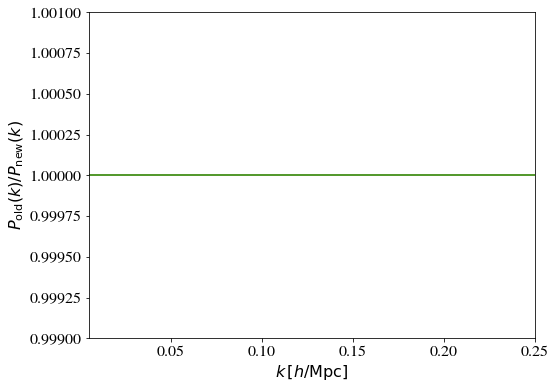

In [42]:
plt.figure()

plt.plot(kdata, birdhex.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, birdhex.fullPs[1]/newpk[1], 'C1-', label = 'quad')
plt.plot(kdata, birdhex.fullPs[2]/newpk[2], 'C2-', label = 'hex')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## Correlation function

PyBird can compute the correlation function multipole. 
We redefine the PyBird classes to include the correlation function multipole. In particular, we set smax=1000 (in Mpc/h) in the Common() class. 

As the resummation is first performed in Fourier space then the IR corrections are spherical Bessel transform to configuration space, enabling the correlation function automatically redefine kmax = 0.5 (h/Mpc) such that the BAO peak will be fully resummed.

In [43]:
sdata = np.linspace(25., 500., 100)

smax = 1000
commoncf = pybird.Common(Nl=3, kmax=kmax, with_cf=True, optiresum=True, accboost=1.)
nonlinear = pybird.NonLinear(load=True, save=False, co=commoncf)
resum = pybird.Resum(co=commoncf)
projection = pybird.Projection(sdata, Om_AP, z_AP, co=commoncf)

In [44]:
magpie = pybird.Bird(cosmobird, with_bias=True, co=commoncf)
nonlinear.PsCf(magpie)
magpie.setPsCf(bdict)
noresumCf = np.copy(magpie.fullCf)
resum.PsCf(magpie)
resumCf = np.copy(magpie.fullCf)
projection.AP(magpie)
projection.xdata(magpie)

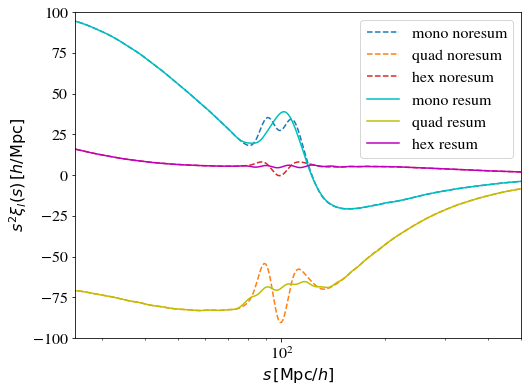

In [45]:
plt.figure()

plt.plot(commoncf.s, commoncf.s**2 * noresumCf[0], 'C0--', label = 'mono noresum')
plt.plot(commoncf.s, commoncf.s**2 * noresumCf[1], 'C1--', label = 'quad noresum')
plt.plot(commoncf.s, commoncf.s**2 * noresumCf[2], 'C3--', label = 'hex noresum')

plt.plot(commoncf.s, commoncf.s**2 * resumCf[0], 'c-', label = 'mono resum')
plt.plot(commoncf.s, commoncf.s**2 * resumCf[1], 'y-', label = 'quad resum')
plt.plot(commoncf.s, commoncf.s**2 * resumCf[2], 'm-', label = 'hex resum')

plt.xscale('log')
plt.xlim(25., 500.)
plt.ylim(-100., 100.)
plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
plt.ylabel(r'$s^2 \xi_l(s) \, [h/\mathrm{Mpc}]$')

plt.legend()

plt.show()

(25.0, 150.0)

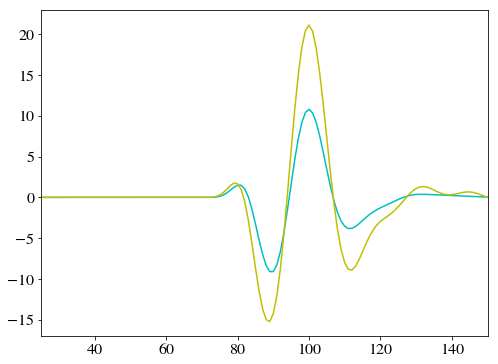

In [46]:
plt.plot(commoncf.s, commoncf.s**2 * (resumCf[0]-noresumCf[0]), 'c-', label = 'mono resum')
plt.plot(commoncf.s, commoncf.s**2 * (resumCf[1]-noresumCf[1]), 'y-', label = 'quad resum')
plt.xlim(25., 150.)
#plt.ylim(-0.0018, 0.0021)

### New interface

In [47]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'multipole': 3,
    'xdata': sdata,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bdict,
    'DA': DA,
    'H': H
})

newcf = correlator.get()

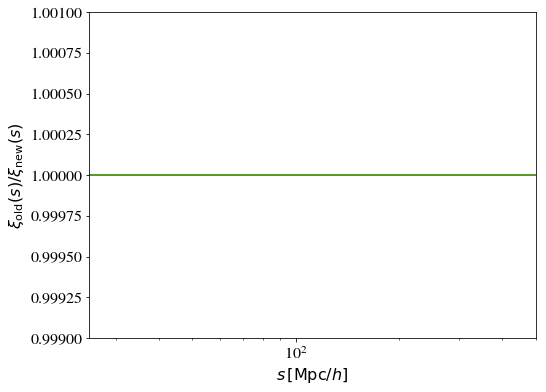

In [48]:
plt.figure()

plt.plot(sdata, magpie.fullCf[0]/newcf[0], 'C0-', label = 'mono')
plt.plot(sdata, magpie.fullCf[1]/newcf[1], 'C1-', label = 'quad')
plt.plot(sdata, magpie.fullCf[2]/newcf[2], 'C2-', label = 'hex')

plt.xscale('log')
plt.xlim(25., 500.)
plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
plt.ylabel(r'$\xi_{\rm old}(s)/\xi_{\rm new}(s)$')
plt.ylim(1-.001, 1+.001)

plt.show()

Again, the correlation function can be evaluated without specifying the EFT parameters

In [49]:
treepie = pybird.Bird(cosmobird, with_bias=False, co=commoncf)
nonlinear.PsCf(treepie)
treepie.setPsCfl()
resum.PsCf(treepie)
projection.AP(treepie)
#projection.Window(treepie)
projection.xdata(treepie)
treepie.setreduceCflb(bdict)

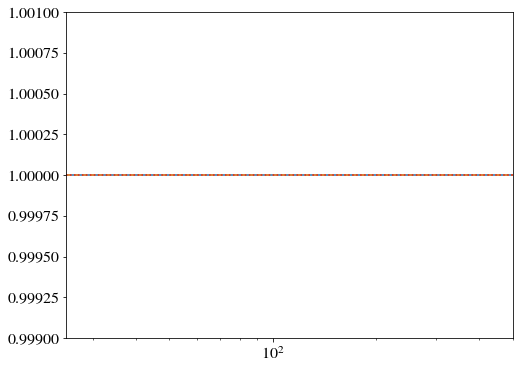

In [50]:
plt.figure()

plt.plot(sdata, treepie.fullCf[0]/magpie.fullCf[0], 'C0-', label = 'mono')
plt.plot(sdata, treepie.fullCf[1]/magpie.fullCf[1], 'C1--', label = 'quad')
plt.plot(sdata, treepie.fullCf[2]/magpie.fullCf[2], 'C3:', label = 'hex')
plt.xlim(25., 500.)
plt.xscale('log')
plt.ylim(1-.001, 1+.001)

plt.show()

### New interface

In [51]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'multipole': 3,
    'with_bias': False,
    'xdata': sdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'DA': DA,
    'H': H
})

newcf = correlator.get(bdict)

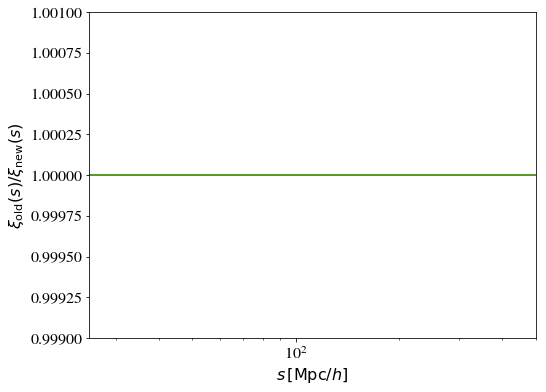

In [52]:
plt.figure()

plt.plot(sdata, treepie.fullCf[0]/newcf[0], 'C0-', label = 'mono')
plt.plot(sdata, treepie.fullCf[1]/newcf[1], 'C1-', label = 'quad')
plt.plot(sdata, treepie.fullCf[2]/newcf[2], 'C2-', label = 'hex')

plt.xscale('log')
plt.xlim(25., 500.)
plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
plt.ylabel(r'$\xi_{\rm old}(s)/\xi_{\rm new}(s)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## Wedges

In [53]:
co = pybird.Common(Nl=3, kmax=kmax, optiresum=True)
nonlinear = pybird.NonLinear(load=True, save=True, co=co)
resum = pybird.Resum(co=co)
projection = pybird.Projection(kdata, Om_AP, z_AP, Nwedges=3, co=co,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='../montepython_tree/data/pybird/Window',
    window_configspace_file='../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z057.dat')

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


In [54]:
bats = pybird.Bird(cosmobird, with_bias=True, co=co)
nonlinear.PsCf(bats)
bats.setPsCf(bdict)
resum.Ps(bats)
projection.AP(bats)
#projection.Window(bats)
projection.Wedges(bats)
projection.xdata(bats)

(0.005, 0.25)

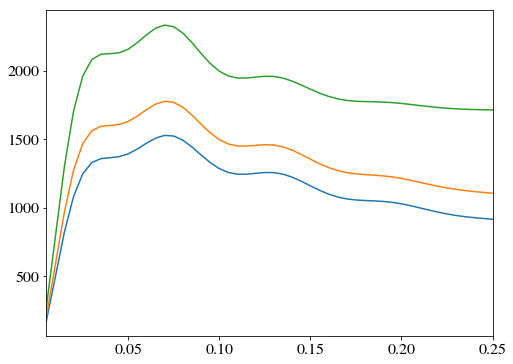

In [55]:
plt.plot(kdata, kdata * bats.fullPs[0])
plt.plot(kdata, kdata * bats.fullPs[1])
plt.plot(kdata, kdata * bats.fullPs[2])
plt.xlim(0.005, 0.25)

### New interface

In [56]:
correlator = pybird.Correlator()


bdict = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }

correlator.set({
    'output': 'bPk',
    'multipole': 3,
    'wedge': 3,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
    
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'DA': DA,
    'H': H,
    'bias': bdict
})

newpk = correlator.get()

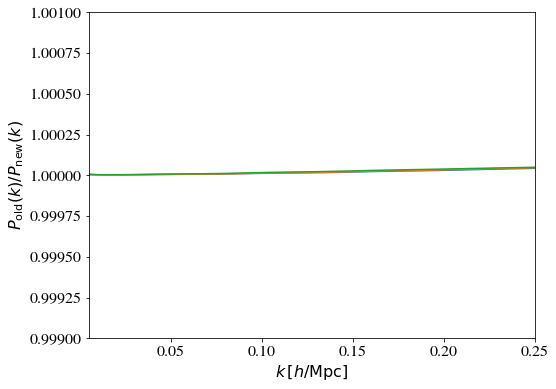

In [57]:
plt.figure()

plt.plot(kdata, bats.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, bats.fullPs[1]/newpk[1], 'C1-', label = 'quad')
plt.plot(kdata, bats.fullPs[2]/newpk[2], 'C2-', label = 'hex')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## Multi skycut

In [58]:
zlow = 1.
Pklow = [M.pk(ki*M.h(), zlow)*M.h()**3 for ki in kk]

flow = M.scale_independent_growth_factor_f(zlow)
DAlow = M.angular_distance(zlow) * M.Hubble(0.)
Hlow = M.Hubble(zlow) / M.Hubble(0.)

cosmolow = {'k11': kk, 'P11': Pklow, 'f': flow, 'DA': DAlow, 'H': Hlow}

common = pybird.Common(Nl=3, kmax=kmax, optiresum=True)
nonlinear = pybird.NonLinear(load=True, save=True, co=common)
resum = pybird.Resum(co=common)
projection = pybird.Projection(kdata, Om_AP, zlow, co=common)

lowbird = pybird.Bird(cosmolow, with_bias=True, co=common)
nonlinear.PsCf(lowbird)
lowbird.setPsCf(bdict)
resum.Ps(lowbird)
projection.AP(lowbird)
projection.xdata(lowbird)

lowbirdPs = np.copy(lowbird.fullPs)

In [59]:
correlator = pybird.Correlator()

D = M.scale_independent_growth_factor(zpk)
Dlow = M.scale_independent_growth_factor(zlow)

correlator.set({
    'output': 'bPk',
    'skycut': 2,
    'multipole': 3, 
    'xdata': [kdata, kdata],
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, zlow],
    'Omega_m_AP': Om_AP,
    
    'with_window': True,
    'windowPk': ['../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057', None],
    'windowCf': ['../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat', None]
    
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': [f, flow],
    'D': [D, Dlow],
    'DA': [DA, DAlow],
    'H': [H, Hlow]
})

newpk = correlator.get([bdict, bdict])

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


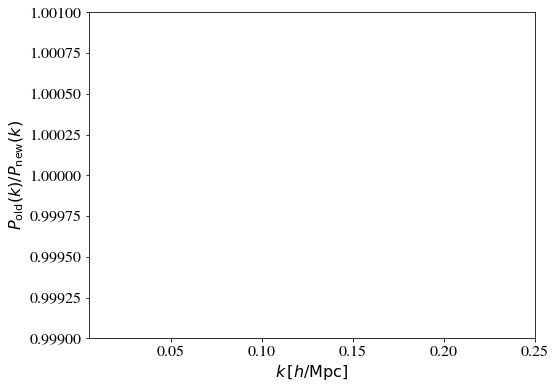

In [60]:
plt.figure()

plt.plot(kdata, birdhex.fullPs[0]/newpk[0][0], 'C0-', label = 'mono')
plt.plot(kdata, birdhex.fullPs[1]/newpk[0][1], 'C1-', label = 'quad')
plt.plot(kdata, birdhex.fullPs[2]/newpk[0][2], 'C2-', label = 'hex')

plt.plot(kdata, lowbird.fullPs[0]/newpk[1][0], 'C0--', label = 'mono')
plt.plot(kdata, lowbird.fullPs[1]/newpk[1][1], 'C1--', label = 'quad')
plt.plot(kdata, lowbird.fullPs[2]/newpk[1][2], 'C2--', label = 'hex')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## With Class

In [61]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 2,
    'multipole': 3, 
    'xdata': kdata,
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, zlow],
    'Omega_m_AP': Om_AP,
    'with_window': True,
    'windowPk': ['../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057', None],
    'windowCf': ['../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat', None]
})

t0 = time()
correlator.compute(cosmo, module='class')
print (time()-t0)

newpk = correlator.get([bdict, bdict])

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy
5.407308101654053


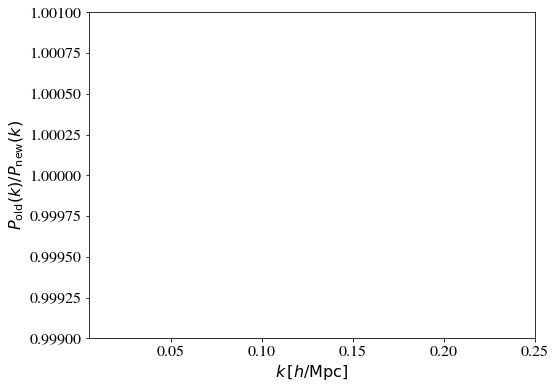

In [62]:
plt.figure()

plt.plot(kdata, birdhex.fullPs[0]/newpk[0][0], 'C0-', label = 'mono')
plt.plot(kdata, birdhex.fullPs[1]/newpk[0][1], 'C1-', label = 'quad')
plt.plot(kdata, birdhex.fullPs[2]/newpk[0][2], 'C2-', label = 'hex')

plt.plot(kdata, lowbird.fullPs[0]/newpk[1][0], 'C0--', label = 'mono')
plt.plot(kdata, lowbird.fullPs[1]/newpk[1][1], 'C1--', label = 'quad')
plt.plot(kdata, lowbird.fullPs[2]/newpk[1][2], 'C2--', label = 'hex')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## multisky one redshift

In [63]:
reload(pybird)

correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 2,
    'multipole': 3, 
    'xdata': kdata,
    'z': [zpk, zpk],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, z_AP],
    'Omega_m_AP': Om_AP,
    'with_window': True,
    'windowPk': ['../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z0p57', None],
    'windowCf': ['../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat', None]
})

t0 = time()
correlator.compute(cosmo, module='class')
print (time()-t0)

newpk = correlator.get([bdict, bdict])

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z0p57_Nl3_kmax0.30.npy
3.433922052383423


(0.999, 1.001)

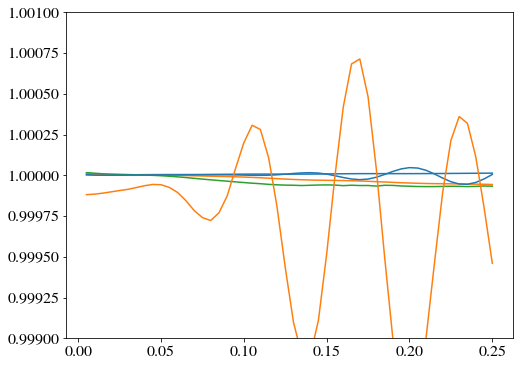

In [64]:
plt.plot(kdata, birdhex.fullPs[0]/newpk[0][0], 'C0-', label = 'mono')
plt.plot(kdata, birdhex.fullPs[1]/newpk[0][1], 'C1-', label = 'quad')
plt.plot(kdata, birdhex.fullPs[2]/newpk[0][2], 'C2-', label = 'hex')

plt.plot(kdata, bird.fullPs[0]/newpk[1][0], 'C0-', label = 'mono')
plt.plot(kdata, bird.fullPs[1]/newpk[1][1], 'C1-', label = 'quad')
plt.ylim(1-.001, 1+.001)

## Multi skycuts: correlation function

In [65]:
common = pybird.Common(Nl=3, with_cf=True, optiresum=True, )
nonlinear = pybird.NonLinear(load=True, save=True, co=common)
resum = pybird.Resum(co=common)
projection = pybird.Projection(sdata, Om_AP, zlow, co=common)

lowbird = pybird.Bird(cosmolow, with_bias=True, co=common)
nonlinear.PsCf(lowbird)
lowbird.setPsCf(bdict)
resum.PsCf(lowbird)
projection.AP(lowbird)
projection.xdata(lowbird)

In [66]:
correlator = pybird.Correlator()

D = M.scale_independent_growth_factor(zpk)
Dlow = M.scale_independent_growth_factor(zlow)

correlator.set({
    'output': 'bCf',
    'skycut': 2,
    'multipole': 3, 
    'xdata': [sdata, sdata],
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, zlow],
    'Omega_m_AP': Om_AP,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': [f, flow],
    'D': [D, Dlow],
    'DA': [DA, DAlow],
    'H': [H, Hlow]
})

newcf = correlator.get([bdict, bdict])

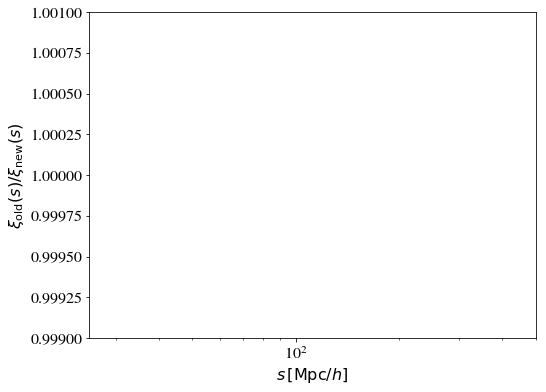

In [67]:
plt.figure()

plt.plot(sdata, magpie.fullCf[0]/newcf[0][0], 'C0-', label = 'mono')
plt.plot(sdata, magpie.fullCf[1]/newcf[0][1], 'C1-', label = 'quad')
plt.plot(sdata, magpie.fullCf[2]/newcf[0][2], 'C2-', label = 'hex')

plt.plot(sdata, lowbird.fullCf[0]/newcf[1][0], 'C0--', label = 'mono')
plt.plot(sdata, lowbird.fullCf[1]/newcf[1][1], 'C1--', label = 'quad')
plt.plot(sdata, lowbird.fullCf[2]/newcf[1][2], 'C2--', label = 'hex')

plt.xscale('log')
plt.xlim(25., 500.)
plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
plt.ylabel(r'$\xi_{\rm old}(s)/\xi_{\rm new}(s)$')
plt.ylim(1-.001, 1+.001)

plt.show()

## Projection on the sky II: redshift dependence

Instead of using a single effective redshift, one can take into account the galaxy count distribution over the redshift bin. 

A typical galaxy count distribution:

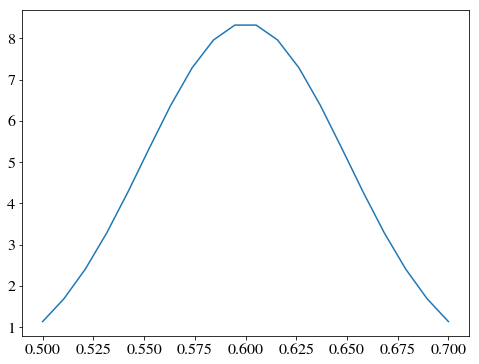

In [68]:
zz = np.linspace(zpk-0.1, zpk+0.1, 20) # Probably 20 points are enough..
# ... we will do a double integral, so the more points given, the more time it will take.

sigmaz = 0.05

def Gaussian(z, p=(zpk, sigmaz)):
    zc, dz = p
    return np.exp(-0.5*(z-zc)**2/dz**2)

nz = Gaussian(zz)
nz /= np.trapz(nz, x=zz)

# zb, _, _, nz = np.loadtxt('dev_window/Density_galaxies_dataBOSSNGC_Dk6.txt', unpack=True)
# zz = np.linspace(zb[0], zb[-1], 30)
# from scipy.interpolate import interp1d
# nz = interp1d(zb, nz, kind='cubic')(zz)
# nz /= np.trapz(nz, x=zz)

plt.plot(zz, nz)
plt.show()

In [69]:
Dz = np.array([M.scale_independent_growth_factor(z) for z in zz])
fz = np.array([M.scale_independent_growth_factor_f(z) for z in zz])

DAz = np.array([M.angular_distance(z) * M.Hubble(0.) for z in zz])
Hz = np.array([M.Hubble(z) / M.Hubble(0.) for z in zz])

Dfid = M.scale_independent_growth_factor(zpk)

First, we compute the growth functions over the redshifts spanned over the bin. 

We add the option redshift='mean' inside the Common class. The AP effect will be applied for each redshift spanned over the bin. 

The resummation is performed on the effective redshift: the difference between the single effective redshift computation and the mean over the redshift bin being sufficiently small, one can neglect the redshift dependence of the IR-resummation inside the redshift bin.

In [70]:
from importlib import reload
reload(pybird)

commonred = pybird.Common(Nl=3, kmax=kmax, optiresum=True, with_time=False)
nonlinear = pybird.NonLinear(load=True, save=True, co=commonred)
resum = pybird.Resum(co=commonred)
projection = pybird.Projection(kdata, Om_AP, zpk, co=commonred, zz=zz, nz=nz)

In [71]:
cosmobird["D"] = D

crow = pybird.Bird(cosmobird, with_bias=False, co=commonred)
nonlinear.PsCf(crow)
crow.setPsCfl()
resum.Ps(crow)

time1 = time()
projection.redshift(crow, Dz, fz, DAz, Hz)
print(time() - time1)

projection.xdata(crow)
crow.setreducePslb(bdict)

0.7623167037963867


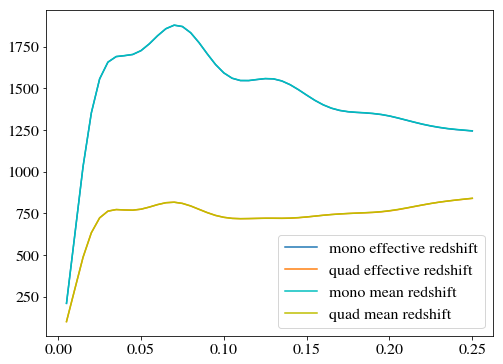

In [72]:
plt.figure()

plt.plot(kdata, kdata * bird.fullPs[0], 'C0-', label = 'mono effective redshift')
plt.plot(kdata, kdata * bird.fullPs[1], 'C1-', label = 'quad effective redshift')

plt.plot(kdata, kdata * crow.fullPs[0], 'c-', label = 'mono mean redshift')
plt.plot(kdata, kdata * crow.fullPs[1], 'y-', label = 'quad mean redshift')

plt.legend()
plt.show()

Observe the difference with the single effective redshift computation. If the distribution is taken to be a delta function (sigmaz -> 0), the difference will fade away.

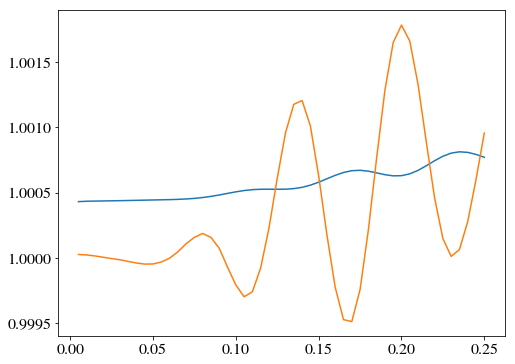

In [73]:
plt.plot(kdata, crow.fullPs[0]/bird.fullPs[0])
plt.plot(kdata, crow.fullPs[1]/bird.fullPs[1])

We add a bird over another redshift...

In [74]:
zzlow = np.linspace(zlow-0.1, zlow+0.1, 20) # Probably 20 points are enough..
# ... we will do a double integral, so the more points given, the more time it will take.

nzlow = Gaussian(zzlow, p=(zlow, sigmaz))
nzlow /= np.trapz(nzlow, x=zzlow)

# plt.plot(zz, nz)
# plt.show()

In [75]:
Dzlow = np.array([M.scale_independent_growth_factor(z) for z in zzlow])
fzlow = np.array([M.scale_independent_growth_factor_f(z) for z in zzlow])

DAzlow = np.array([M.angular_distance(z) * M.Hubble(0.) for z in zzlow])
Hzlow = np.array([M.Hubble(z) / M.Hubble(0.) for z in zzlow])

Dfidlow = M.scale_independent_growth_factor(zlow)

In [76]:
cosmolow["D"] = Dfidlow

projectionlow = pybird.Projection(kdata, Om_AP, zlow, zz=zzlow, nz=nzlow, co=commonred)
crowlow = pybird.Bird(cosmolow, with_bias=False, co=commonred)
nonlinear.PsCf(crowlow)
crowlow.setPsCfl()
resum.Ps(crowlow)

time1 = time()
projectionlow.redshift(crowlow, Dzlow, fzlow, DAzlow, Hzlow)
print(time() - time1)

projectionlow.xdata(crowlow)
crowlow.setreducePslb(bdict)

0.72751784324646


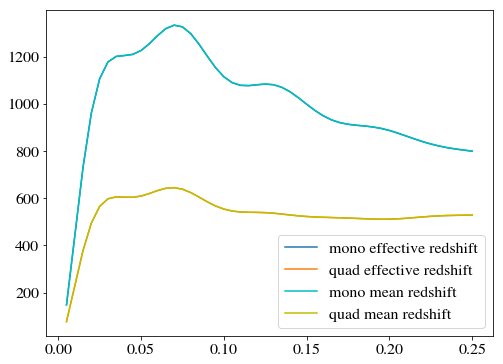

In [77]:
plt.figure()

plt.plot(kdata, kdata * lowbirdPs[0], 'C0-', label = 'mono effective redshift')
plt.plot(kdata, kdata * lowbirdPs[1], 'C1-', label = 'quad effective redshift')

plt.plot(kdata, kdata * crowlow.fullPs[0], 'c-', label = 'mono mean redshift')
plt.plot(kdata, kdata * crowlow.fullPs[1], 'y-', label = 'quad mean redshift')

plt.legend()
plt.show()

### New interface

In [78]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': zz,
    'nz': nz,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'D': Dfid,
    'f': f,
    'fz': fz,
    'Dz': Dz,
    'DAz': DAz,
    'Hz': Hz
})

newpk = correlator.get(bdict)

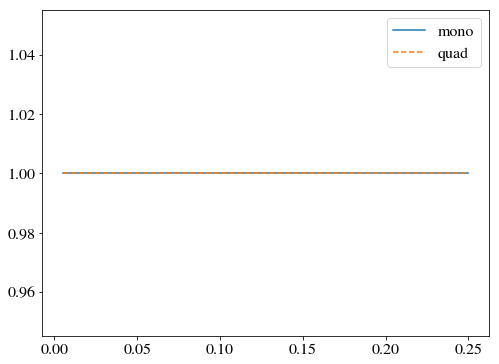

In [79]:
plt.figure()

plt.plot(kdata, newpk[0]/crow.fullPs[0], 'C0-', label = 'mono')
plt.plot(kdata, newpk[1]/crow.fullPs[1], 'C1--', label = 'quad')

plt.legend()
plt.show()

In [80]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 2,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': [zz, zzlow],
    'nz': [nz, nzlow],
    'xdata': [kdata, kdata],
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, zlow],
    'Omega_m_AP': Om_AP,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': [f, flow],
    'D': [Dfid, Dfidlow],
    'fz': [fz, fzlow],
    'Dz': [Dz, Dzlow],
    'DAz': [DAz, DAzlow],
    'Hz': [Hz, Hzlow]
})

newpk = correlator.get([bdict, bdict])

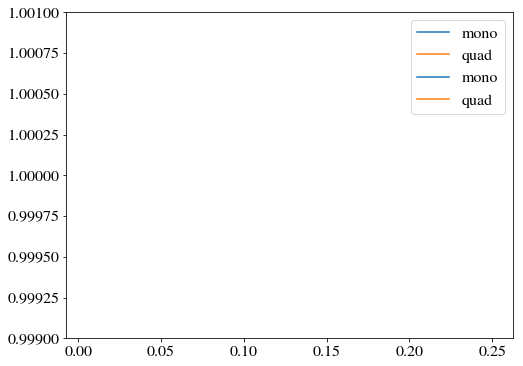

In [81]:
plt.figure()

plt.plot(kdata, newpk[0][0]/crow.fullPs[0], 'C0-', label = 'mono')
plt.plot(kdata, newpk[0][1]/crow.fullPs[1], 'C1-', label = 'quad')

plt.plot(kdata, newpk[1][0]/crowlow.fullPs[0], 'C0-', label = 'mono')
plt.plot(kdata, newpk[1][1]/crowlow.fullPs[1], 'C1-', label = 'quad')

plt.ylim(1-.001, 1+.001)

plt.legend()
plt.show()

### Correlation function with redshift dependence

In [82]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'skycut': 2,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': [zz, zzlow],
    'nz': [nz, nzlow],
    'xdata': [sdata, sdata],
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, zlow],
    'Omega_m_AP': Om_AP,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': [f, flow],
    'D': [Dfid, Dfidlow],
    'fz': [fz, fzlow],
    'Dz': [Dz, Dzlow],
    'DAz': [DAz, DAzlow],
    'Hz': [Hz, Hzlow]
})

newcf = correlator.get([bdict, bdict])

(0.999, 1.001)

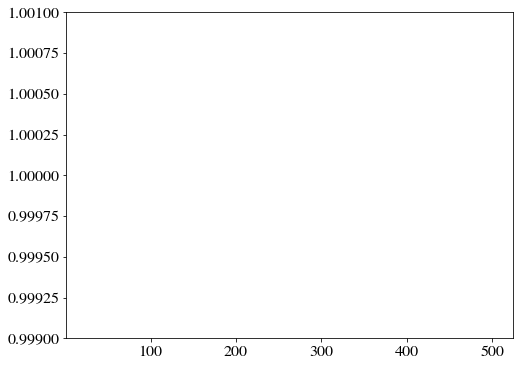

In [83]:
plt.figure()

plt.plot(sdata, magpie.fullCf[0]/newcf[0][0], 'C0-', label = 'mono')
plt.plot(sdata, magpie.fullCf[1]/newcf[0][1], 'C1-', label = 'quad')
#plt.plot(sdata, magpie.fullCf[2]/newcf[0,2], 'C2-', label = 'hex')

plt.plot(sdata, lowbird.fullCf[0]/newcf[1][0], 'C0--', label = 'mono')
plt.plot(sdata, lowbird.fullCf[1]/newcf[1][1], 'C1--', label = 'quad')
#plt.plot(sdata, lowbird.fullCf[2]/newcf[1,2], 'C2--', label = 'hex')

plt.ylim(1-.001, 1+.001)


### with class

In [84]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': zz,
    'nz': nz,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute(cosmo, module='class')

newpk = correlator.get(bdict)

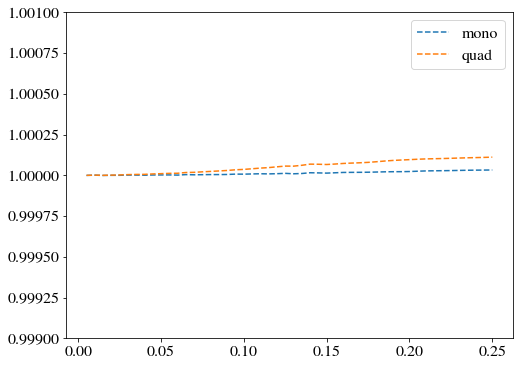

In [85]:
plt.figure()

plt.plot(kdata, newpk[0]/crow.fullPs[0], 'C0--', label = 'mono')
plt.plot(kdata, newpk[1]/crow.fullPs[1], 'C1--', label = 'quad')

plt.ylim(1-.001, 1+.001)

plt.legend()
plt.show()

In [86]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 2,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': [zz, zzlow],
    'nz': [nz, nzlow],
    'xdata': [kdata, kdata],
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': [z_AP, zlow],
    'Omega_m_AP': Om_AP,
})

correlator.compute(cosmo, module='class')

newpk = correlator.get([bdict, bdict])

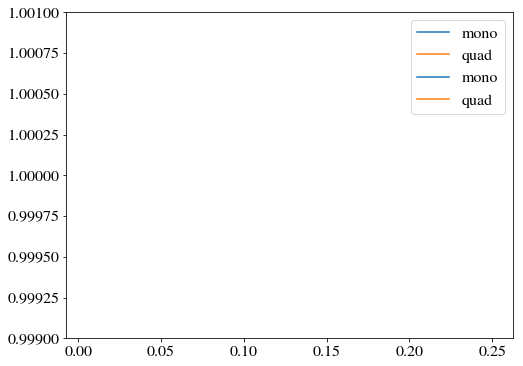

In [87]:
plt.figure()

plt.plot(kdata, newpk[0][0]/crow.fullPs[0], 'C0-', label = 'mono')
plt.plot(kdata, newpk[0][1]/crow.fullPs[1], 'C1-', label = 'quad')

plt.plot(kdata, newpk[1][0]/crowlow.fullPs[0], 'C0-', label = 'mono')
plt.plot(kdata, newpk[1][1]/crowlow.fullPs[1], 'C1-', label = 'quad')

plt.ylim(1-.001, 1+.001)

plt.legend()
plt.show()

### Check redshift dependence with a delta distribtuion

In [88]:
zzdelta = np.linspace(zpk-2e-2, zpk+2e-2, 20) # Probably 20 points are enough..
# ... we will do a double integral, so the more points given, the more time it will take.

nzdelta = Gaussian(zzdelta, p=(zpk, 1e-2))
nzdelta /= np.trapz(nzdelta, x=zzdelta)

In [89]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': zzdelta,
    'nz': nzdelta,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute(cosmo, module='class')

newpk = correlator.get(bdict)

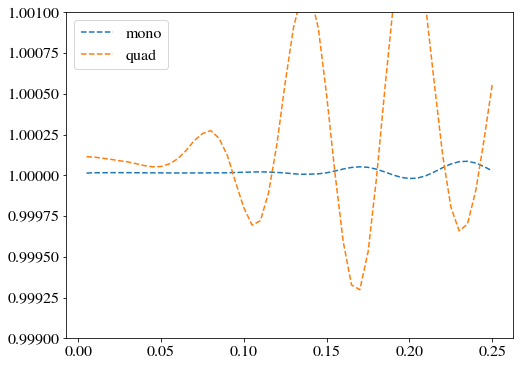

In [90]:
plt.figure()

plt.plot(kdata, newpk[0]/bird.fullPs[0], 'C0--', label = 'mono')
plt.plot(kdata, newpk[1]/bird.fullPs[1], 'C1--', label = 'quad')

plt.ylim(1-.001, 1+.001)

plt.legend()
plt.show()

In [91]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'skycut': 1,
    'multipole': 3, 
    'with_redshift_bin': True,
    'zz': zzdelta,
    'nz': nzdelta,
    'xdata': sdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute(cosmo, module='class')

newcf = correlator.get(bdict)

[]

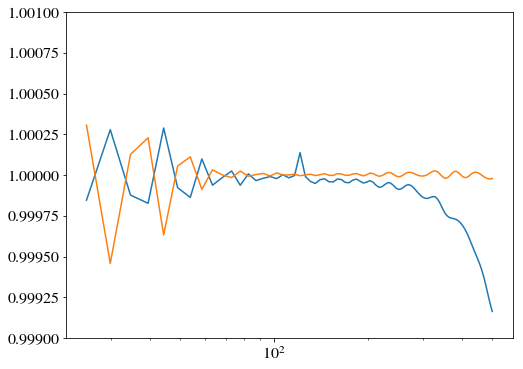

In [92]:
plt.figure()

plt.plot(sdata, magpie.fullCf[0]/newcf[0], 'C0-', label = 'mono')
plt.plot(sdata, magpie.fullCf[1]/newcf[1], 'C1-', label = 'quad')
#plt.plot(sdata, magpie.fullCf[2]/newcf[2], 'C2-', label = 'hex')
plt.ylim(1-.001, 1+.001)
plt.xscale('log')

plt.plot()

## Angular correlation function

In [93]:
tam = np.geomspace(10., 300., 30)
tdata = tam * np.pi/(60. * 180.) 

correlator = pybird.Correlator()

bw = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4] }

correlator.set({
    'output': 'w',
    'skycut': 1,
    'zz': zz,
    'nz': nz,
    'xdata': tdata,
    'z': zpk,
    'with_resum': False
})

correlator.compute(cosmo, module='class')

w = correlator.get(bw)

In [94]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'w',
    'skycut': 1,
    'zz': zzlow,
    'nz': nzlow,
    'xdata': tdata,
    'z': zlow,
    'with_resum': False
})

correlator.compute(cosmo, module='class')

wlow = correlator.get(bw)

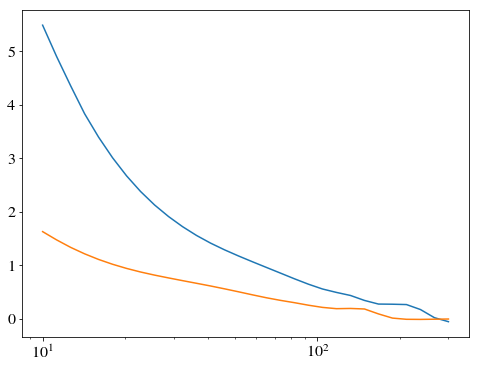

In [95]:
plt.plot(tam, tam * w)
plt.plot(tam, tam * wlow)
plt.xscale('log')

In [96]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'w',
    'skycut': 3,
    'zz': [zz, zzlow, zzlow],
    'nz': [nz, nzlow, nzlow],
    'xdata': tdata,
    'z': [zpk, zlow, zlow],
    'with_resum': False
})

correlator.compute(cosmo, module='class')

wmulti = correlator.get([bw, bw, bw])

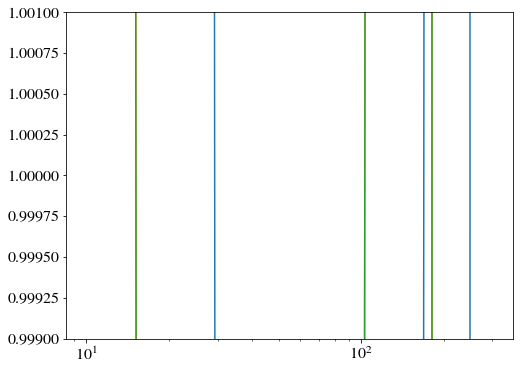

In [97]:
plt.plot(tam, w/wmulti[0])
plt.plot(tam, wlow/wmulti[1])
plt.plot(tam, wlow/wmulti[2])
plt.ylim(1-.001, 1+.001)

plt.xscale('log')

### Exact time dependence

In [98]:
reload(pybird)

commoneds = pybird.Common(Nl=3, kmax=kmax, optiresum=True, exact_time=False)
nonlinear = pybird.NonLinear(load=True, save=True, co=commoneds)
resum = pybird.Resum(co=commoneds)
projection = pybird.Projection(kdata, Om_AP, z_AP, co=commoneds,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='../montepython_tree/data/pybird/Window',
    window_configspace_file='../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat')

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


In [99]:
cosmobird = {
    'k11': kk,
    'P11': Pk,
    'f': f,
    'DA': DA,
    'H': H,
    #'D': D,
    'z': zpk,
    'Omega0_m': M.Omega0_m()
}

birdeds = pybird.Bird(cosmology=cosmobird, with_bias=True, co=commoneds)
nonlinear.PsCf(birdeds)
birdeds.setPsCf(bdict)
resum.Ps(birdeds)
projection.AP(birdeds)
#projection.Window(birdexact)
projection.xdata(birdeds)

In [100]:
commonexact = pybird.Common(Nl=3, kmax=kmax, optiresum=True, exact_time=True)
nonlinear = pybird.NonLinear(load=True, save=True, co=commonexact)
resum = pybird.Resum(co=commonexact)
projection = pybird.Projection(kdata, Om_AP, z_AP, co=commonexact,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='../montepython_tree/data/pybird/Window',
    window_configspace_file='../montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat')

Loaded mask: ../montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


In [101]:
birdexact = pybird.Bird(cosmology=cosmobird, with_bias=False, co=commonexact)
nonlinear.PsCf(birdexact)
birdexact.setPsCfl()
resum.Ps(birdexact)
projection.AP(birdexact)
#projection.Window(birdexact)
projection.xdata(birdexact)
birdexact.setreducePslb(bdict)
print (0., 3/7., 1/7., 1.)

0.0 0.42857142857142855 0.14285714285714285 1.0


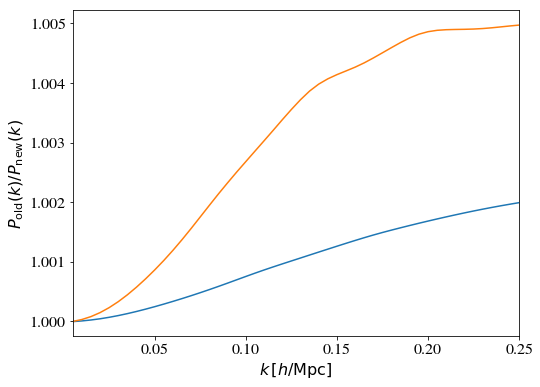

In [102]:
plt.figure()

plt.plot(kdata, birdexact.fullPs[0]/birdeds.fullPs[0], 'C0-', label = 'mono')
plt.plot(kdata, birdexact.fullPs[1]/birdeds.fullPs[1], 'C1-', label = 'quad')
#plt.plot(kdata, birdeds.fullPs[2]/birdexact.fullPs[2], 'C2-', label = 'hex')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
#plt.ylim(1-.001, 1+.001)

plt.show()

### New interface

In [103]:
reload(pybird)

correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_exact_time': True,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute(cosmo, module='class')

newpk = correlator.get(bdict)

(0.999, 1.001)

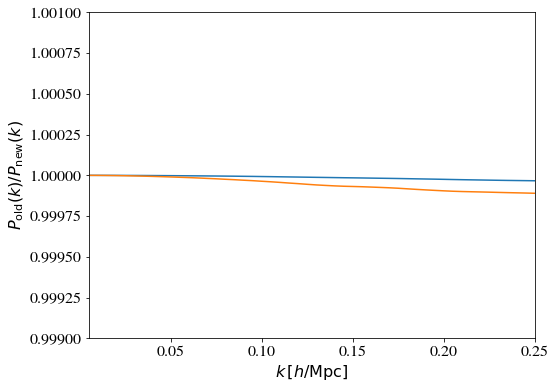

In [104]:
plt.plot(kdata, birdexact.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, birdexact.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

In [105]:
zc = zpk# + 0.1
zzdelta = np.linspace(zc-1e-4, zc+1e-4, 20) 
nzdelta = Gaussian(zzdelta, p=(zc, 1e-4))
nzdelta /= np.trapz(nzdelta, x=zzdelta)

In [106]:
reload(pybird)

correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_exact_time': True,
    # 'with_time': False,
    'with_redshift_bin': True,
    'zz': zzdelta,
    'nz': nzdelta,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_AP': True,
    'z_AP': z_AP,
    'Omega_m_AP': Om_AP,
})

correlator.compute(cosmo, module='class')

newpk = correlator.get(bdict)

(0.999, 1.001)

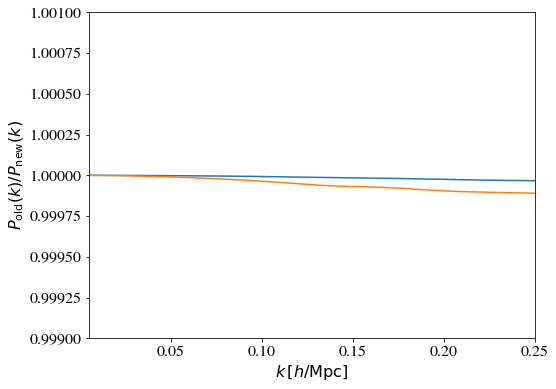

In [107]:
plt.plot(kdata, birdexact.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, birdexact.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

### Exact time on wcdm

In [108]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_exact_time': True,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
})

cosmow =  {'ln10^{10}A_s': 3.044,
       'n_s': 0.9649,
       'h': 0.6736,
       'omega_b': 0.02237,
       'omega_cdm': 0.120,
        'Omega_Lambda': 0.,
        'w0_fld': -1.
      }
correlator.compute(cosmow, module='class')

newpk = correlator.get(bdict)

(0.999, 1.001)

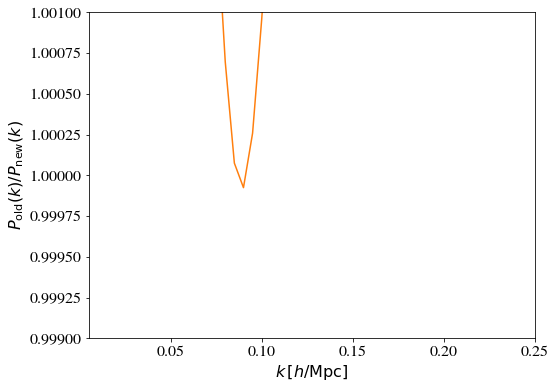

In [109]:
plt.plot(kdata, birdexact.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, birdexact.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

In [110]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'with_exact_time': True,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
})

cosmow =  {'ln10^{10}A_s': 3.044,
       'n_s': 0.9649,
       'h': 0.6736,
       'omega_b': 0.02237,
       'omega_cdm': 0.120,
        'Omega_Lambda': 0.,
        'w0_fld': -.8
      }

correlator.compute(cosmow, module='class')

newpk = correlator.get(bdict)

In [111]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    #'with_exact_time': True,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
})

correlator.compute(cosmow, module='class')

newpkeds = correlator.get(bdict)

Text(0, 0.5, '$P_{\\rm old}(k)/P_{\\rm new}(k)$')

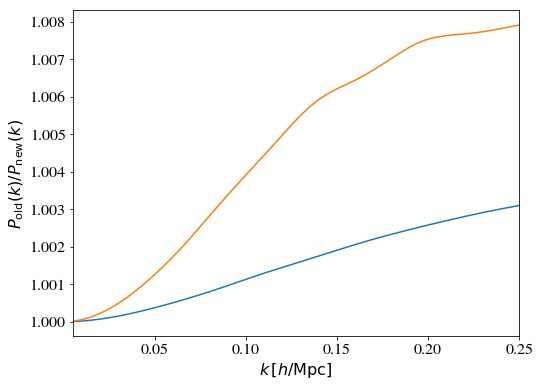

In [112]:
plt.plot(kdata, newpk[0]/newpkeds[0], 'C0-', label = 'mono')
plt.plot(kdata, newpk[1]/newpkeds[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
#plt.ylim(1-.001, 1+.001)

### Clustering quintessence

In [113]:
reload(pybird)

correlator = pybird.Correlator()

bdict = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    #'with_exact_time': True,
    'with_quintessence': True,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
})

cosmow =  {'ln10^{10}A_s': 3.044,
       'n_s': 0.9649,
       'h': 0.6736,
       'omega_b': 0.02237,
       'omega_cdm': 0.120,
        'Omega_Lambda': 0.,
        'w0_fld': -1.
      }
correlator.compute(cosmow, module='class')

newpk = correlator.get(bdict)

(0.999, 1.001)

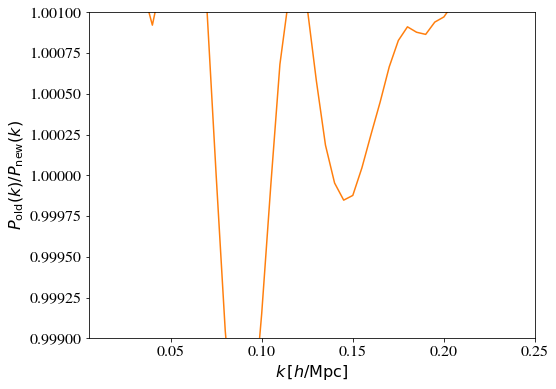

In [114]:
plt.plot(kdata, birdexact.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, birdexact.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
plt.ylim(1-.001, 1+.001)

In [115]:
reload(pybird)

correlator = pybird.Correlator()

bdict = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }

correlator.set({
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    #'with_exact_time': True,
    'with_quintessence': True,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
})

cosmow =  {'ln10^{10}A_s': 3.044,
       'n_s': 0.9649,
       'h': 0.6736,
       'omega_b': 0.02237,
       'omega_cdm': 0.120,
        'Omega_Lambda': 0.,
        'w0_fld': -0.9
      }
correlator.compute(cosmow, module='class')

newpk = correlator.get(bdict)

Text(0, 0.5, '$P_{\\rm old}(k)/P_{\\rm new}(k)$')

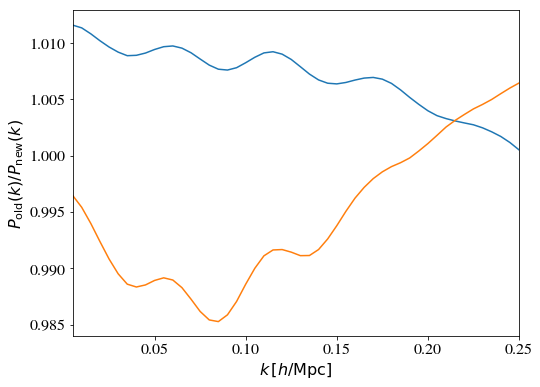

In [116]:
plt.plot(kdata, birdeds.fullPs[0]/newpk[0], 'C0-', label = 'mono')
plt.plot(kdata, birdeds.fullPs[1]/newpk[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
#plt.ylim(1-.001, 1+.001)

### Caching

In [119]:
reload(pybird)

correlator = pybird.Correlator()

config = {
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
}

correlator.set(config)

correlator.compute(cosmo, module='class')

cache_dict = correlator.cache(as_dict=True)
cache_bird = correlator.cache(as_dict=False)

directpk = correlator.get(bdict)

In [120]:
biascorrelator = pybird.BiasCorrelator()

biascorrelator.set(config)

biascorrelator.setcache(cache_dict, as_dict=True)

#biascorrelator.setcache(cache_bird, as_dict=False)

cachepk = biascorrelator.get(bdict)

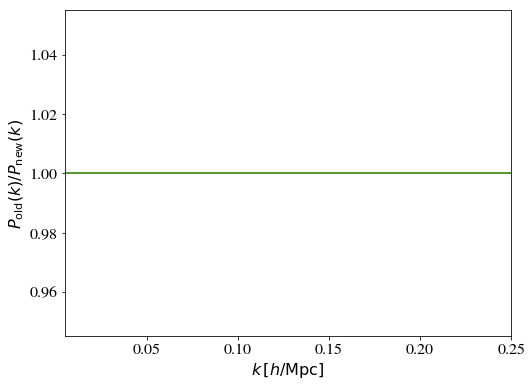

In [121]:
plt.plot(kdata, cachepk[0]/directpk[0], 'C0-', label = 'mono')
plt.plot(kdata, cachepk[1]/directpk[1], 'C1-', label = 'quad')
plt.plot(kdata, cachepk[2]/directpk[2], 'C2-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
#plt.ylim(1-.001, 1+.001)
plt.show()

In [122]:
correlator = pybird.Correlator()

configmulti = {
    'output': 'bPk',
    'skycut': 2,
    'multipole': 3, 
    'xdata': [kdata, kdata],
    'z': [zpk, zlow],
    'optiresum': True,
    'kmax': 0.3    
}

correlator.set(configmulti)

correlator.compute(cosmo, module='class')

cache_dict = correlator.cache(as_dict=True)
cache_bird = correlator.cache(as_dict=False)

directpk = correlator.get([bdict, bdict])

In [123]:
biascorrelator = pybird.BiasCorrelator()

biascorrelator.set(configmulti)

biascorrelator.setcache(cache_dict, as_dict=True)

#biascorrelator.setcache(cache_bird, as_dict=False)

cachepk = biascorrelator.get([bdict, bdict])

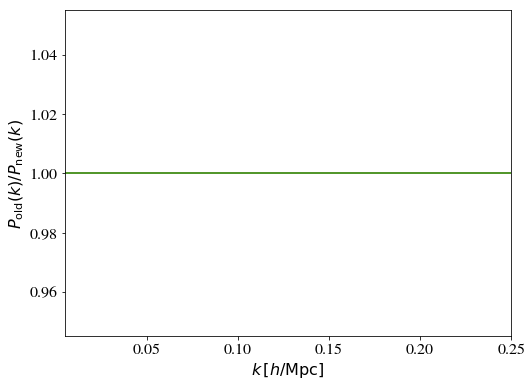

In [124]:
plt.plot(kdata, cachepk[0][0]/directpk[0][0], 'C0-', label = 'mono')
plt.plot(kdata, cachepk[0][1]/directpk[0][1], 'C1-', label = 'quad')
plt.plot(kdata, cachepk[0][2]/directpk[0][2], 'C2-', label = 'quad')

plt.plot(kdata, cachepk[1][0]/directpk[1][0], 'C0-', label = 'mono')
plt.plot(kdata, cachepk[1][1]/directpk[1][1], 'C1-', label = 'quad')
plt.plot(kdata, cachepk[1][2]/directpk[1][2], 'C2-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm old}(k)/P_{\rm new}(k)$')
#plt.ylim(1-.001, 1+.001)
plt.show()

### Tidal alignments

In [181]:
from importlib import reload
reload(pybird)

bdict = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }
#############
correlator = pybird.Correlator()

config = {
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
}

correlator.set(config)
correlator.compute(cosmo, module='class')
normalpk = correlator.get(bdict)
#############

bta = bdict.copy()
bta["bq"] = 0.

correlator = pybird.Correlator()

config = {
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_tidal_alignments': True,
    #'with_bias': True
}

cosmobias = cosmo.copy()
# cosmobias['bias'] = bta

correlator.set(config)
correlator.compute(cosmobias, module='class')
chameleonpk = correlator.get(bta)

(0.999, 1.001)

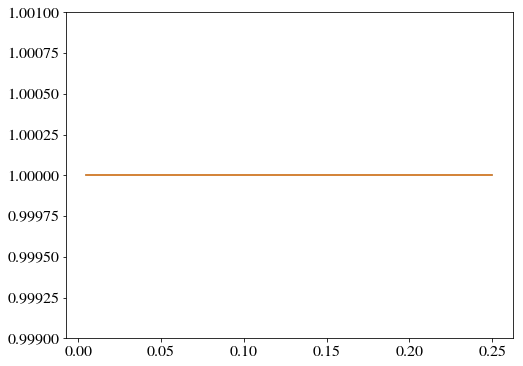

In [187]:
plt.plot(kdata, chameleonpk[0]/normalpk[0])
plt.plot(kdata, chameleonpk[1]/normalpk[1])
plt.ylim(1-.001, 1+.001)

In [183]:
#############
bta = bdict.copy()
bta["bq"] = -0.02
correlator = pybird.Correlator()

config = {
    'output': 'bPk',
    'skycut': 1,
    'multipole': 3, 
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_tidal_alignments': True
}

correlator.set(config)
correlator.compute(cosmo, module='class')
tapk = correlator.get(bta)

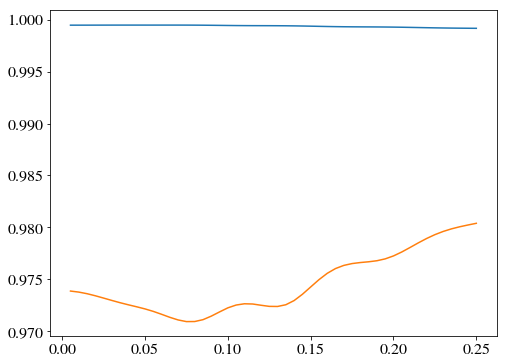

In [188]:
plt.plot(kdata, tapk[0]/normalpk[0])
plt.plot(kdata, tapk[1]/normalpk[1])

## (N)NLO counterterm: k^4 P11

In [ ]:
from copy import copy
reload(pybird)

bnlo = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6], "bnlo": 2. }

correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'multipole': 3,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
    'with_nlo_bias': True
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bnlo,
    'DA': DA,
    'H': H
})

pk_with_nlo_bias = correlator.get()

#####

correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'multipole': 3,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_nlo_bias': True
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'DA': DA,
    'H': H
})

pk_with_nlo_bias_marg = correlator.get(bnlo)

#####

bd = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }

correlator = pybird.Correlator()

correlator.set({
    'output': 'bPk',
    'multipole': 3,
    'xdata': kdata,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bd,
    'DA': DA,
    'H': H
})

pk = correlator.get()

In [ ]:
plt.plot(kdata, kdata*pk[0])
plt.plot(kdata, kdata*pk_with_nlo_bias[0])

In [ ]:
plt.plot(kdata, pk[0]/pk_with_nlo_bias[0])
plt.plot(kdata, pk_with_nlo_bias_marg[0]/pk_with_nlo_bias[0])

plt.plot(kdata, pk[1]/pk_with_nlo_bias[1])
plt.plot(kdata, pk_with_nlo_bias_marg[1]/pk_with_nlo_bias[1])

plt.plot(kdata, pk[2]/pk_with_nlo_bias[2])
plt.plot(kdata, pk_with_nlo_bias_marg[2]/pk_with_nlo_bias[2])

plt.ylim(1-.005, 1+.001)

In [ ]:
from copy import copy
reload(pybird)

ss = np.arange(1., 200., 1.)

bnlo = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6], "bnlo": 4. }

correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'multipole': 3,
    'xdata': ss,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
    'with_nlo_bias': True
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bnlo,
    'DA': DA,
    'H': H
})

cf_with_nlo_bias = correlator.get()

#####

correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'multipole': 3,
    'xdata': ss,
    'z': zpk,
    'optiresum': True,
    'kmax': 0.3,
    'with_nlo_bias': True
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'DA': DA,
    'H': H
})

cf_with_nlo_bias_marg = correlator.get(bnlo)

#####

bd = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }

correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'multipole': 3,
    'xdata': ss,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bd,
    'DA': DA,
    'H': H
})

cf = correlator.get()

In [ ]:
plt.plot(ss, cf[0]/cf_with_nlo_bias_marg[0])
#plt.plot(ss, cf_with_nlo_bias_marg[0]/cf_with_nlo_bias[0])

# plt.plot(ss, cf[1]/cf_with_nlo_bias_marg[1])
# plt.plot(ss, cf_with_nlo_bias_marg[1]/cf_with_nlo_bias[1])

plt.ylim(1-.005, 1+.001)
plt.xlim(0, 30)

In [ ]:
plt.plot(ss, ss**2*(cf[0]-cf_with_nlo_bias[0]))
#plt.plot(ss, ss**2*cf[0])
plt.plot(ss, -2**2*4./ss**2)
plt.xlim(2, 20)

In [ ]:
bd = { "b1": bs[0], "b2": bs[1], "b3": bs[2], "b4": bs[3], "cct": bs[4], "cr1": bs[5], "cr2": bs[6] }

ss = np.arange(1., 200., 1.)

correlator = pybird.Correlator()

correlator.set({
    'output': 'bCf',
    'multipole': 3,
    'xdata': ss,
    'z': zpk,
    'optiresum': True,
    'with_bias': True,
    'kmax': 0.3,
})

correlator.compute({
    'k11': kk,
    'P11': Pk,
    'f': f,
    'bias': bd,
    'DA': DA,
    'H': H
})

cf = correlator.get()

In [ ]:
CF = correlator.bird.Cf[:,:,:len(ss)]
plt.plot(ss, ss**2 *  CF[0,0])
plt.plot(ss, ss**2 *  CF[1,0])
plt.plot(ss, ss**2 *  CF[1,0]**2/CF[0,0])
plt.ylim(-20, 50)
plt.xlim(5, 20)


In [ ]:
plt.plot(ss, CF[1,0]**2/CF[0,0]**2)
plt.ylim(0, 0+0.01)